# ZAD 1

In [1]:
from PIL import Image, ImageOps, ImageFont, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import string
from collections import defaultdict

In [2]:
def find_patterns(original_image, pattern_image, min_val, if_fish=False, fish_transform_val=100):
    img = Image.open(original_image)
    img_comp = img.load()  # loading image components
    w, h = img.size
    gray_scale = img.convert('L')
    inverted = ImageOps.invert(gray_scale)
    transformed = np.array(inverted)
    if if_fish:   # fish image has to be transformed because it has small contrast
        transformed = np.abs(transformed - fish_transform_val)
    main_img = np.swapaxes(transformed, 0, 1)  # flipping image
    plt.imshow(main_img, cmap='gray')
    plt.show()
    dft = np.fft.fft2(main_img)   # fourier transformation
    
    pattern = Image.open(pattern_image)
    pattern_w, pattern_h = pattern.size
    gray_pattern = pattern.convert('L')
    inverted_pattern = ImageOps.invert(gray_pattern)
    transformed_pattern = np.array(inverted_pattern)
    plt.imshow(transformed_pattern, cmap='gray')
    plt.show()
    if if_fish:
        transformed_pattern= np.abs(transformed_pattern - 120)
    looked_pattern = np.swapaxes(transformed_pattern, 0 , 1)
    
    C = np.real(np.fft.ifft2( np.multiply( dft, np.fft.fft2(np.rot90(looked_pattern, 2), s=(w, h))))) # counting corelation
    C_min_v = min_val * (np.max(C) - np.min(C)) + np.min(C)   # min_val adjust
    
    
    for x, y in np.argwhere(C >= C_min_v):
        x = int(x)
        y = int(y)
        for pw in range(pattern_w):
            for ph in range(pattern_h):
                r, g, b = img_comp[x-pw, y-ph]
                img_comp[x-pw, y-ph] = (r+100, g-50, b+100)
               
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.show()
    

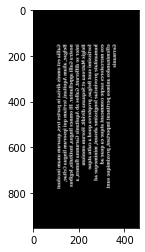

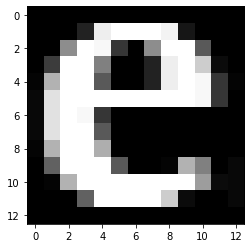

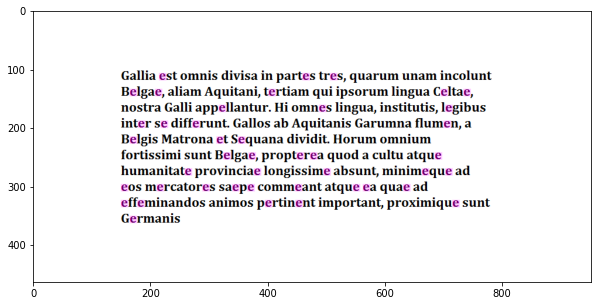

In [3]:
find_patterns('galia.png', 'galia_e.png', 0.9)

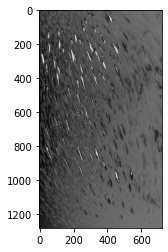

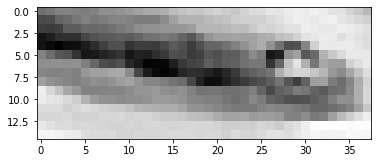

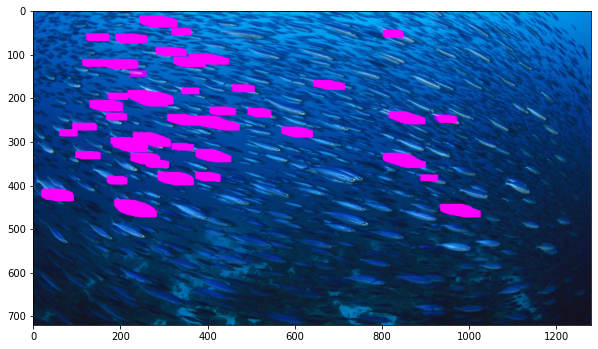

In [4]:
find_patterns('school.jpg', 'fish1.png', 0.6, if_fish=True, fish_transform_val=120)

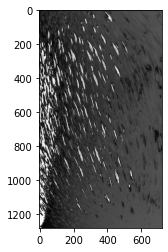

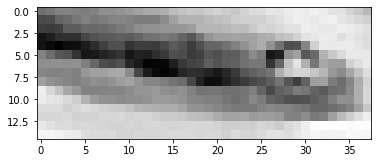

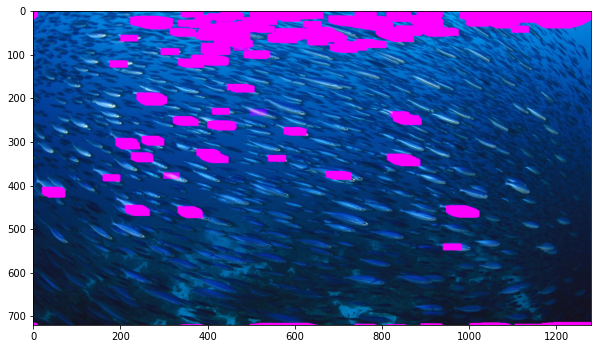

In [5]:
find_patterns('school.jpg', 'fish1.png', 0.6, if_fish=True, fish_transform_val=150)

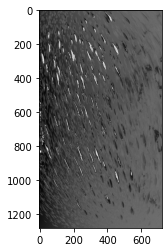

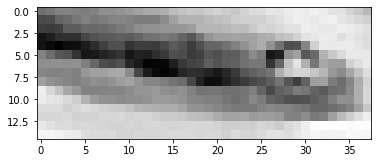

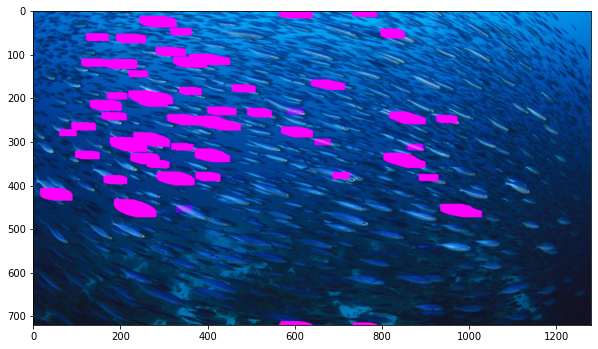

In [6]:
find_patterns('school.jpg', 'fish1.png', 0.6, if_fish=True, fish_transform_val=125)

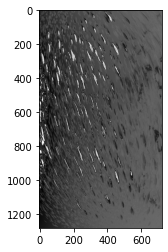

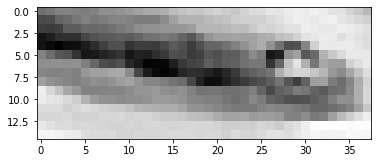

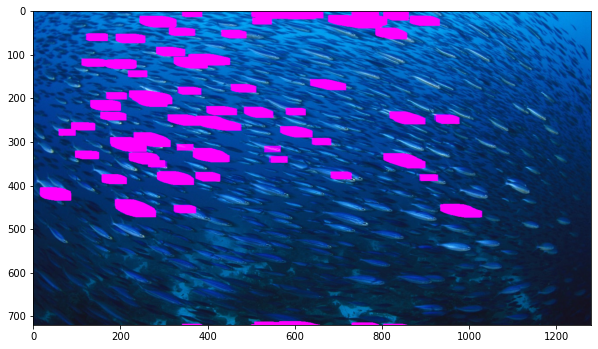

In [7]:
find_patterns('school.jpg', 'fish1.png', 0.6, if_fish=True, fish_transform_val=130)

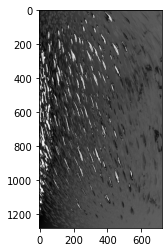

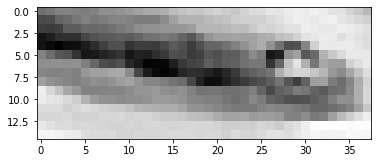

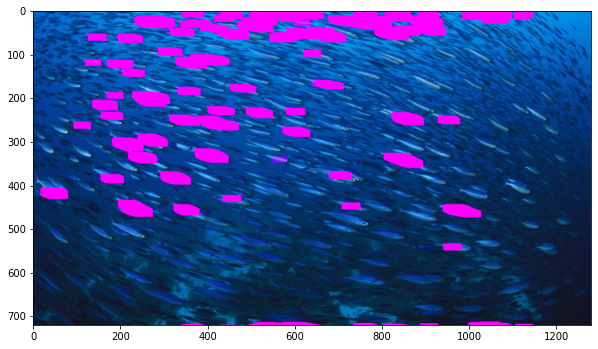

In [8]:
find_patterns('school.jpg', 'fish1.png', 0.6, if_fish=True, fish_transform_val=140)

# ZAD 2 OCR

## Opis algorytmu
## Algorytm ocr działa w następujący sposób:
##    - Wszytuje obraz do rozpoznania oraz odpowiednią czcionke z pliku ttf
##    - Tworzy obrazy liter, cyfr oraz znaków wybranej czcionki, a następnie przeskalowuje je oraz obraz do rozpoznania (najpierw na szarą skale, obraca kolory, odwraca obraz)
##    - Oblicza splot dla każdego znaku czcionki (Wybrany tu został na drodze eksperymentu próg korelacji C = 0.0001)
##    - Zapisuje w tablicy znaków rozpoznanych, znak, jego korelacje, pozycje, oraz wymiary)
##    - Na podstawie posortowanej tablicy rozpoznanych znaków, względem pozycji y a następnie x, zlicza wystąpienia znaku oraz wypisuje rozpoznany znak (algorytm pozbywa się szumów ignorująć osamotnione kropki oraz przecinki) 

In [9]:
def ocr(original_img, font):
    let_scale = 3
    font = ImageFont.truetype(font, 40)
    img = Image.open(original_img)
    plt.imshow(img, cmap='gray')
    plt.show()
    img_comp = img.load()  # loading image components
    w, h = img.size
    gray_scale = img.convert('L')
    inverted = ImageOps.invert(gray_scale)
    transformed = np.array(inverted)
    main_img = np.swapaxes(transformed, 0, 1)  # flipping image
    dft = np.fft.fft2(main_img)   # fourier transformation
    
    rec_list = []
    
    pattern_letters = 'ABCDEFGHIJKLMNOPQRSTUWVXYZabcdefghijklmnopqrstuwvxyz0123456789,.?!'
    
    for let in pattern_letters:
        pattern_w, pattern_h = font.getsize(let)
        pat_img = Image.new('RGB', (pattern_w, pattern_h), color='white')
        ImageDraw.Draw(pat_img).text((0, 0), let, font=font, fill='black')
        gray_pat = pat_img.convert('L')
        inv_pat = ImageOps.invert(gray_pat)
        trans_pat = np.array(inv_pat)
        ready_pat = np.swapaxes(trans_pat, 0 ,1)
        
        C_pattern = np.max(np.real(np.fft.ifft2(np.multiply(np.fft.fft2(ready_pat),np.fft.fft2(np.rot90(ready_pat, 2))))))
        C = np.abs(np.real(np.fft.ifft2(np.multiply(dft,np.fft.fft2(np.rot90(ready_pat, 2), s=(w, h))))) / C_pattern - 1.0)
        
        C_error = 0.0001 # threshold
        
        for width in range(w):
            for height in range(h):
                if C[width][height] < C_error:
                    w0, h0 = width-pattern_w, height-pattern_h
                    rec_list.append((w0, h0, C[width][height], let, pattern_w, pattern_h))
        
    let_w, let_h = font.getsize('l')
    spc_w, spc_h = font.getsize(' ')
    
    spc_w_scale = spc_w * 0.8
        
    w_ratio, h_ratio = let_w, let_h//let_scale
        
    letter_recognition = defaultdict(dict)
        
    for cand in rec_list:
        width, height, C, let, pattern_w, pattern_h = cand
        box_w, box_h = width // w_ratio, height // h_ratio
        if box_h not in letter_recognition:
            letter_recognition[box_h][box_w] = cand
        elif box_w not in letter_recognition[box_h]:
            letter_recognition[box_h][box_w] = cand
        elif letter_recognition[box_h][box_w][0] < C:
            letter_recognition[box_h][box_w] = cand
    let_count = {}
    for box_h in sorted(letter_recognition):
        p = None
        for box_w in sorted(letter_recognition[box_h]):
            width, height, C, let, pattern_w, pattern_h = letter_recognition[box_h][box_w]
            
            if p is not None:
                p_width, p_height, p_C, p_let, p_pat_w, p_pat_h = p
                if p_width + p_pat_w + spc_w_scale < width:
                    print(' ', end='')
            elif let in ",.":
                continue
            
            print(let, end='')
            if let in let_count:
                let_count[let] += 1
            else:
                let_count[let] = 1

            p = letter_recognition[box_h][box_w]
        if p is not None:
            print('', end='\r\n')
    print(let_count)
            
            
    

## Testy
### Poniżej przedstawiono 4 testy, po 2 na czcionke, jeden z krótkim wyrażeniem, drugi z długim wyrażeniem

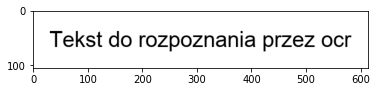

Tekst do rozpoznania przez ocr
{'T': 1, 'e': 2, 'k': 1, 's': 1, 't': 1, 'd': 1, 'o': 4, 'r': 3, 'z': 4, 'p': 2, 'n': 2, 'a': 2, 'i': 1, 'c': 1}


In [10]:
ocr("a1.png", "arial.ttf")

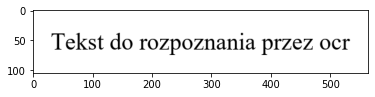

Tekst do rozpoznania przez ocr
{'T': 1, 'e': 2, 'k': 1, 's': 1, 't': 1, 'd': 1, 'o': 4, 'r': 3, 'z': 4, 'p': 2, 'n': 2, 'a': 2, 'i': 1, 'c': 1}


In [11]:
ocr("t1.png", "times.ttf")

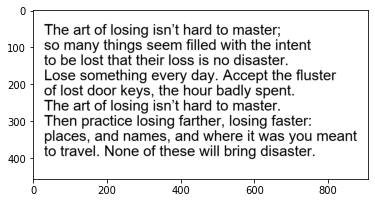

The a of losing isn t hard to master
so many things seem filled with the intent
to be lost that their loss is no disaster.
Lose something ever day. Accept the fluster
of lost door keys, the hour badly spent.
The a of losing isn t hard to master.
Then practice losing fa her, losing faster
places, and names, and where it was you meant
to travel. None of these will bring disaster.
{'T': 3, 'h': 17, 'e': 36, 'a': 22, 'o': 24, 'f': 8, 'l': 15, 's': 30, 'i': 19, 'n': 20, 'g': 7, 't': 32, 'r': 17, 'd': 10, 'm': 7, 'y': 5, 'w': 4, 'b': 3, '.': 6, 'L': 1, 'v': 2, 'A': 1, 'c': 5, 'p': 4, 'u': 3, 'k': 1, ',': 4, 'N': 1}


In [12]:
ocr("a2.png", "arial.ttf")

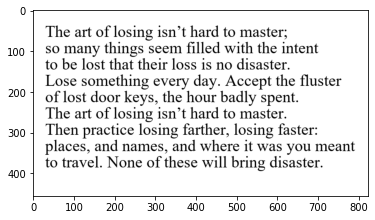

The ar oflosing isn t hard to master
so many things seem lled with the intent
to be lost that their loss is no disaster.
Lose something ever day. Accept the uster
oflost door keys, the hour badly sp.ent.
The ar oflosing isn t hard to master.
Then practice losing far her, losing faster
p.laces, and names, and where it was you meant
to travel. None ofthese will bring disaster.
{'T': 3, 'h': 17, 'e': 36, 'a': 22, 'r': 20, 'o': 24, 'f': 6, 'l': 14, 's': 30, 'i': 18, 'n': 20, 'g': 7, 't': 32, 'd': 10, 'm': 7, 'y': 5, 'w': 4, 'b': 3, '.': 8, 'L': 1, 'v': 2, 'A': 1, 'c': 5, 'p': 4, 'u': 3, 'k': 1, ',': 4, 'N': 1}


In [13]:
ocr("t2.png", "times.ttf")

# Wnioski
### - Rozpoznawanie tekstu na obrazach jest na tyle trudnym zadaniem, że pomimo posiadania dokładnych wzorców liter, algorytm nie był w stanie rozpoznać tekstu poprawnie w 100%
### - W mojej opini algorytm radzi sobie lepiej z czcionkami bezszeryfowymi